In [1]:
import pandas as pd
import numpy as np
import os.path
from os import path
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from opm import util
pd.set_option('display.max_rows', 500)

In [2]:
import sqlite3
conn = sqlite3.connect('sqlite-database.db')
contributions = pd.read_sql_query("SELECT * from jira_contribution", conn, parse_dates=["date"])


In [3]:
c = contributions[["identifier","author","type","owner"]].groupby(["author","type","owner"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[c.author != c.owner][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


,contributions
author,
hadoopqa,3115
hudson,2464
anu,1837
genericqa,1130
xyao,894
elek,754
arpitagarwal,643
ppogde,628
nandakumar131,585


## Contributors per participations in JIRA which are not created by self (commenting/helping JIRA)

In [4]:
c = contributions[contributions.author != contributions.owner][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
hudson,1904
hadoopqa,1127
anu,899
ppogde,623
xyao,484
arpitagarwal,411
elek,368
genericqa,356
msingh,306


## Contributors per participations in any issue

In [5]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
hudson,1904
anu,1134
hadoopqa,1127
elek,1019
xyao,729
ppogde,685
msingh,646
bharatviswa,645
nandakumar131,592


# Bus factor (number of contributors responsible for the 50% of the issue creations) from last half year

## Contributors until the half of the all contributions

In [6]:
prcreated = contributions[contributions.type == "JIRA_CREATED"]
prcreated = prcreated[prcreated.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

,author,identifier,cs,ratio
0,elek,85,85,11.470985
1,adoroszlai,80,165,10.796221
2,bharatviswa,41,206,5.533063
3,rakeshr,39,245,5.263158
4,glengeng,39,284,5.263158
5,shashikant,36,320,4.858300
6,avijayan,31,351,4.183536


## Pony number (bus factor)

In [7]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

8

## Dev power (All the contributions in the ration of the top contributor)

In [8]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

8.717647058823529

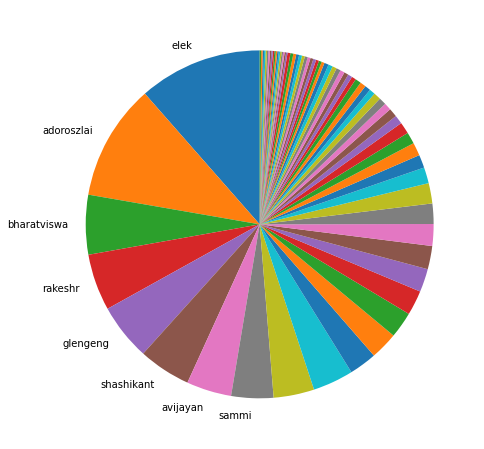

In [9]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created JIRAs > commented JIRA

In [10]:
created = contributions[contributions.type == "JIRA_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[contributions.author != contributions.owner][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

# merged.index = merged.index.rename("githubname")
# merged = merged.join(github_apache_membership.set_index("githubname")).reset_index()
# merged.role = merged.role.fillna("?")
# merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})
merged = merged.reset_index()

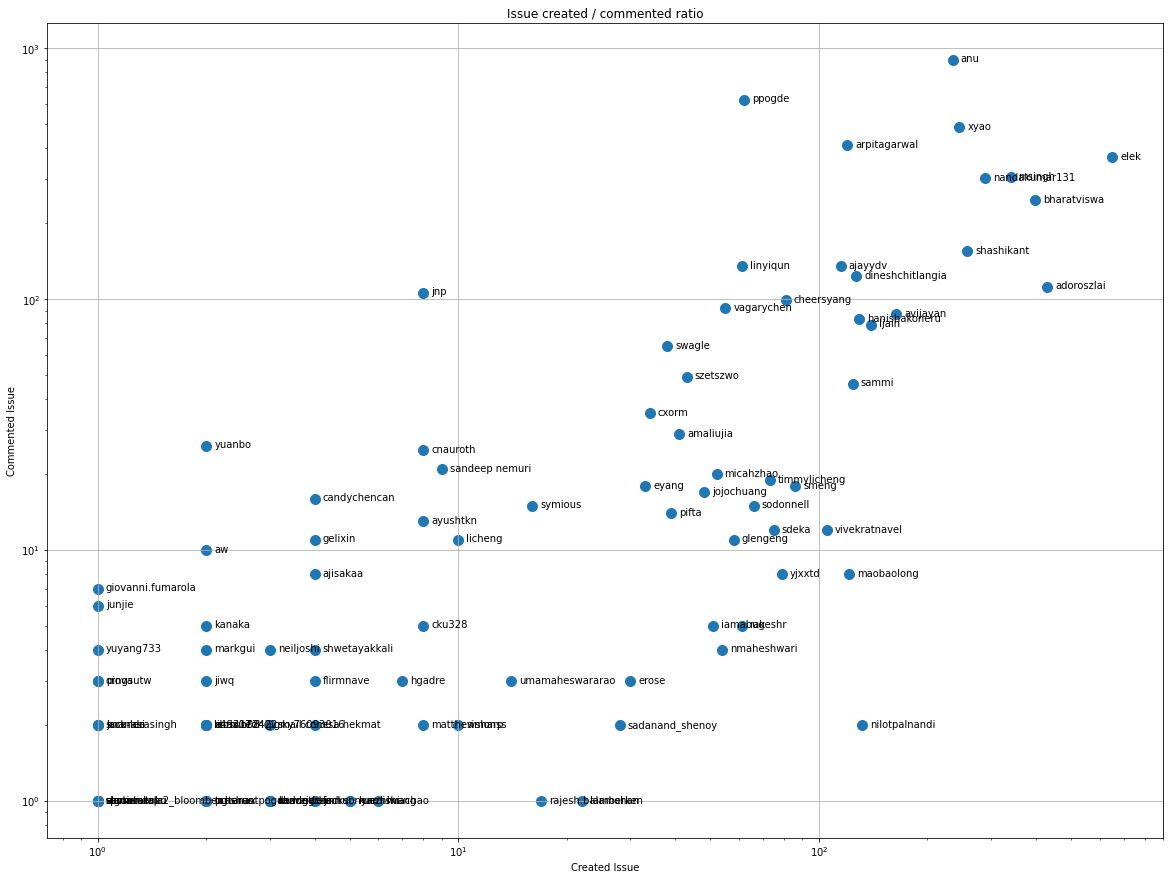

In [11]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped, s= 100)

plt.xlabel('Created Issue')
plt.ylabel('Commented Issue')
plt.title('Issue created / commented ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["author"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

## Same graph with focusing to the last 6 month

Only contributors with both created pr and helped pr visible

In [12]:
import datetime

filtered = contributions[contributions.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
created = filtered[filtered.type == "JIRA_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = filtered[filtered.author != filtered.owner][["identifier"]].groupby([filtered.author,filtered.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created,left_index=True, right_index=True)
merged = merged.reset_index()

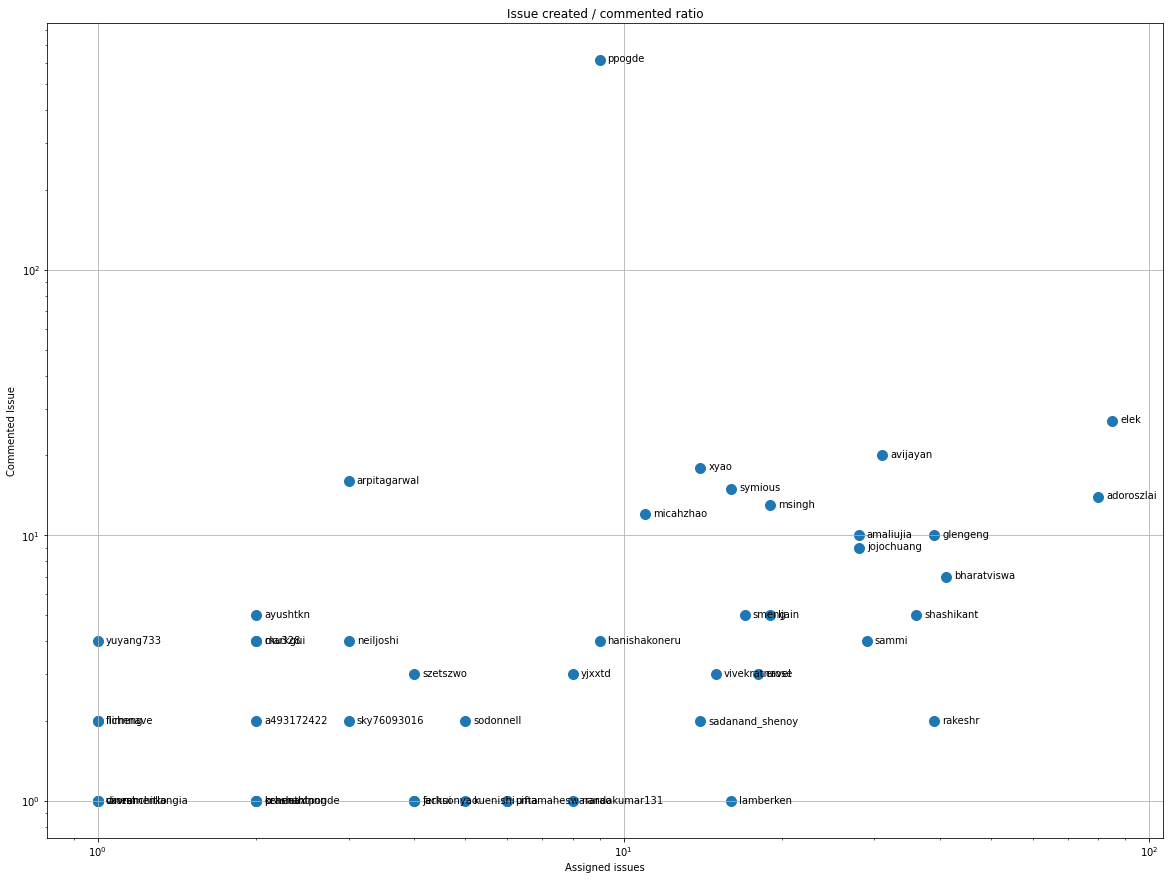

In [13]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped, s= 100)

plt.xlabel('Assigned issues')
plt.ylabel('Commented Issue')
plt.title('Issue created / commented ratio')
plt.grid()

for index, row in source.iterrows():
    plt.annotate(row["author"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
        
plt.semilogx()
plt.semilogy()
plt.show()


# Number of individual contributors per month

Number of different Jira users who either created ssue or commented Issue


In [14]:
m = contributions[["identifier"]].groupby([contributions.date.dt.strftime('%Y').rename("year"),contributions.date.dt.strftime('%m').rename("month"),contributions.author]).count() \
  .reset_index()
result = m[["author"]].groupby([m.year,m.month]).count().sort_values(["year","month"]).reset_index()
result = result.pivot(index="year",columns="month",values="author").fillna(0)


Text(0.5, 1.0, 'Number of induvidual contributors per month')

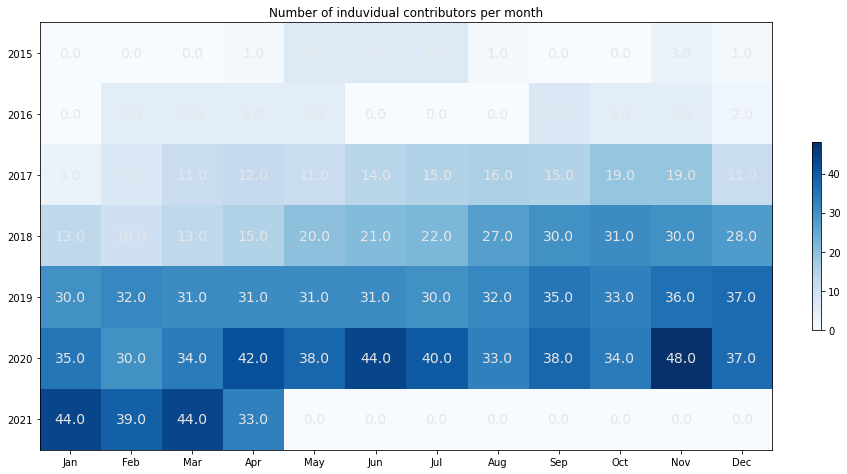

In [15]:
util.create_mosaic(result, "Blues")
plt.title("Number of induvidual contributors per month")

# JIRA activity heatmap

In [16]:
days = contributions.date.dt.strftime('%A')
hours = contributions.date.dt.strftime('%H')

a = contributions[["date"]].groupby([days,hours]).count()
a.columns = ["count"]
a.index.names = ["day","hour"]
a = a.reset_index()
a = a.pivot(index="day",columns="hour",values="count")
a = a.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])


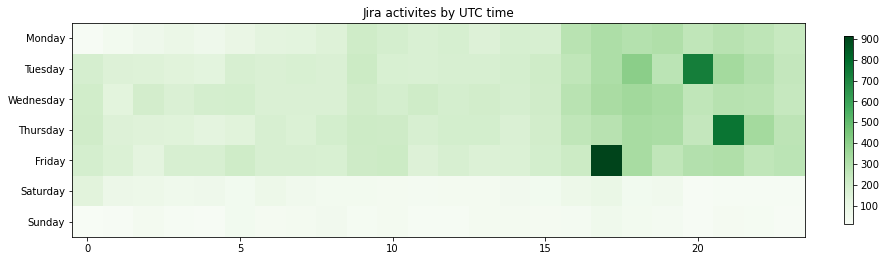

In [17]:
plt.figure(figsize=(14,11))
im = plt.imshow(a, cmap="Greens")
plt.yticks(range(len(a)),a.index.values)
plt.title("Jira activites by UTC time")
plt.colorbar(im, fraction=0.012)
plt.show()
